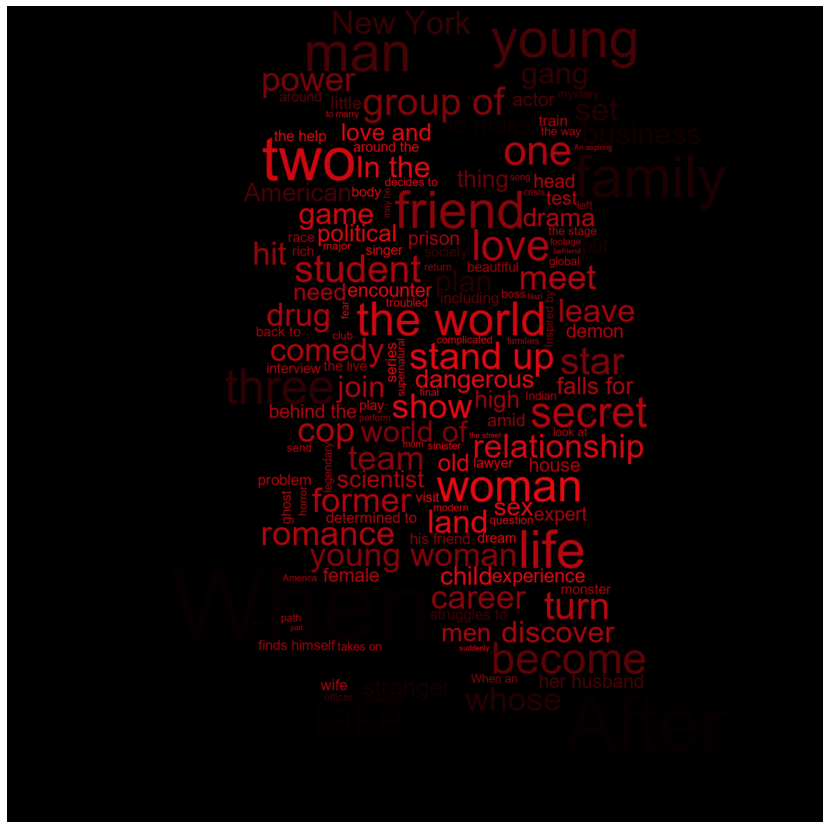

In [6]:
import pandas as pd
import re

import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt

movies = pd.read_csv("Netflix_all.csv")
descriptions = [row.description for index, row in movies.query('description != "-1"').iterrows()]

data2 = pd.DataFrame(descriptions).rename(columns={0:"text"})
text = " ".join(string for string in data2.text)

mask = np.array(Image.open("img/net.jpg"))
wordcloud = WordCloud(background_color="black", max_words=500, mask=mask, min_font_size=5, mode="RGBA", font_path="arial").generate(text)
image_cols = ImageColorGenerator(mask)
#wordcloud.to_file("wc_greyscale.png")  

plt.figure(figsize=[15,15])
plt.imshow(wordcloud.recolor(color_func=image_cols), interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
import plotly.graph_objects as go

def mean(nums):
    if len(nums) == 0 or nums[0] == -1:
        return -1
    sum = 0
    for i in nums:
        sum += i
    return sum / len(nums)

for e,f in movies.query('description != "-1"').iterrows():
    if "Drama" not in f[10]:
        movies = movies.drop([e])

descs_and_rating = [(row.description, row.averageRating) for index, row in movies.query('description != "-1"').iterrows()]

common_nouns = []
for line in open("nouns.txt", "r"):
    common_nouns.append(ascii(line).replace("'","").split("\\")[0])

descs_and_rating
unique_words = {}
for e in descs_and_rating:
    for j in re.sub(r"[.,/()\-\":]|(\'s)", "", e[0]).split(" "):
        word = j.lower()
        if common_nouns.__contains__(word):
            if word in unique_words:
                unique_words[word] = (unique_words[word][0]+1, unique_words[word][1] + [e[1]])
            else:
                unique_words[word] = (1, [])

for k,v in unique_words.items():
    unique_words[k] = (v[0], mean(v[1]))

data = pd.DataFrame.from_dict(unique_words, orient='index').reset_index().rename(columns={"index" : "Noun", 0 : "occurence", 1 : "averageRating"}).sort_values(by="averageRating", ascending=False)

data = data.query('occurence > 50 and averageRating != -1')

fig = go.Figure(data=go.Scatter(x=data['averageRating'], y=data['occurence'], mode='markers', marker_color=data['occurence'], text=data['Noun']))
fig.update_layout(title="The average rating of a Drama film based on word occurence in description")
fig.show()